In [4]:
import json
import pandas as pd
import numpy as np
from datetime import datetime
import prettytable as pt
from matplotlib import pyplot as plt
import os 
import warnings
warnings.filterwarnings("ignore")

###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################

directory = os.path.normpath(os.getcwd() + os.sep + os.pardir+ os.sep + os.pardir)
datadirectory=directory+"/data/yielddata/yielddata.csv"
yielddata = pd.read_csv(datadirectory)
yielddata = yielddata.replace(np.nan, '', regex=True) 


In [5]:
# Fix parameters for building yield curve instruments
instrumentsconfig={
             "OIS": {
               "frequency": "Annual",
               "businessDayConvention": "ModifiedFollowing"
             },
             "DEPO": {
               "businessDayConvention": "ModifiedFollowing",
               "dayCounter": "Actual360"
             }
           }

In [6]:
# Fix parameters for building yield curve

yieldcurveconfig={
        "settlementDays": 2,
        "intpMethod": "Linear",
        "currency": "EUR",
        "calendar": "TARGET",
        "dayCounter": "Actual365Fixed",
        "period": "1D",
        "instruments":instrumentsconfig,}

In [7]:
yieldcurveconfig

{'settlementDays': 2,
 'intpMethod': 'Linear',
 'currency': 'EUR',
 'calendar': 'TARGET',
 'dayCounter': 'Actual365Fixed',
 'period': '1D',
 'instruments': {'OIS': {'frequency': 'Annual',
   'businessDayConvention': 'ModifiedFollowing'},
  'DEPO': {'businessDayConvention': 'ModifiedFollowing',
   'dayCounter': 'Actual360'}}}

In [8]:
yieldcurve =  {
    "valuationDate": "2021-03-10",
    "yieldCurve":yieldcurveconfig ,
    "yieldData": yielddata.to_dict('r')
}
try:
    result = api.createTask(CalculationType.YIELD_CURVE, yieldcurve,True)
    result=json.loads(result["result"])
except RhoovaError as e:
    e.printPretty()

In [9]:
zerorates=result.get("zeroRates"),
discountrates=result.get("discountRates")
dates=[]
forwarddates= {}
rhoovayieldcurvedicts = {}
rhoovayieldcurvediscounts = {}
for rhvzr in zerorates[0]:
    rhoovayieldcurvedicts[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100
    dates.append(rhvzr.get('date'))

for rhv in discountrates:
    rhoovayieldcurvediscounts[datetime.strptime(rhv.get('date'), '%Y-%m-%d').date()] = rhv.get('rate')
    

In [10]:
bloombergzerorates=[-0.47700,-0.48363,-0.48669,-0.48925,-0.4893,-0.49092,-0.49103,-0.49265,-0.49377,-0.49489,-0.49565,
                -0.4956,-0.49571,-0.49708,-0.49694,-0.49703,-0.49783,-0.49804,-0.4832,-0.47168,-0.42914,-0.37548,
                -0.31472,-0.24578,-0.18482,-0.1166,-0.0543,0.00925,0.06995,0.20776,0.32847,0.35852,0.34694,0.33768,
                0.32052,0.29055]
bloombergdiscountrates=[1.0,1.00004,1.000093,1.000188,1.000416,1.000821,1.001265,1.001648,1.002072,1.002512,1.00291,
                          1.003332,1.003755,1.004176,1.004626,1.00501,1.007516,1.010024,1.012173,1.014264,1.017326,
                          1.018962,1.019071,1.017374,1.014906,1.010556,1.005448,0.998983,0.991631,0.969295,0.936376,
                          0.914215,0.901084,0.888445,0.879578,0.8647023]


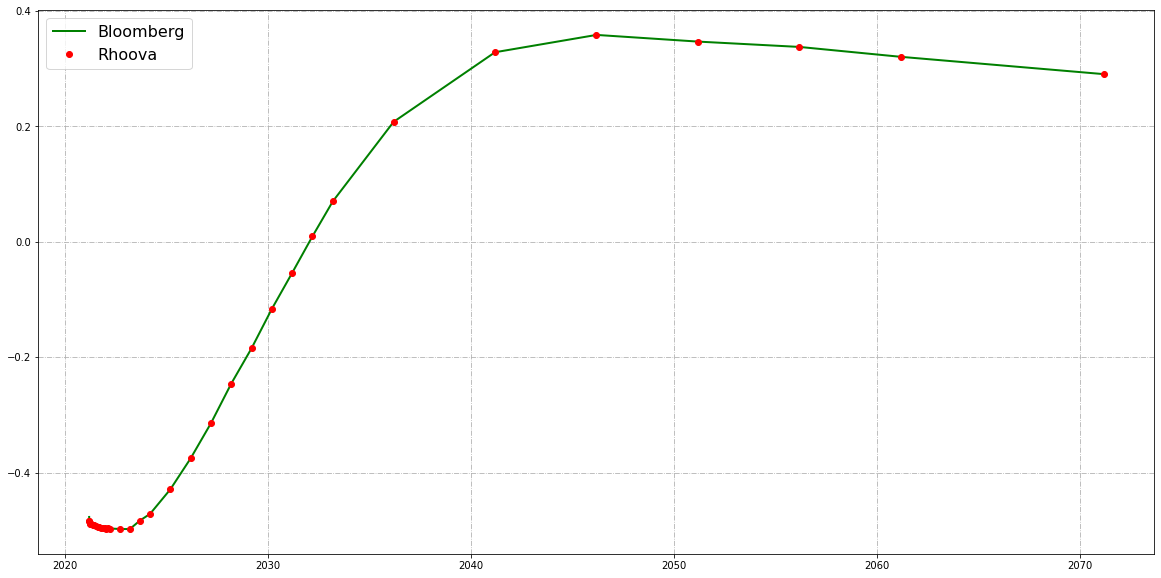

In [11]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvedicts.keys())
y1 =bloombergzerorates
y2 = list(rhoovayieldcurvedicts.values())


ax.plot(x,y1, 'g', label='Bloomberg', linewidth=2)
ax.plot(x,y2, 'ro', label='Rhoova', linewidth=4)
#
leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

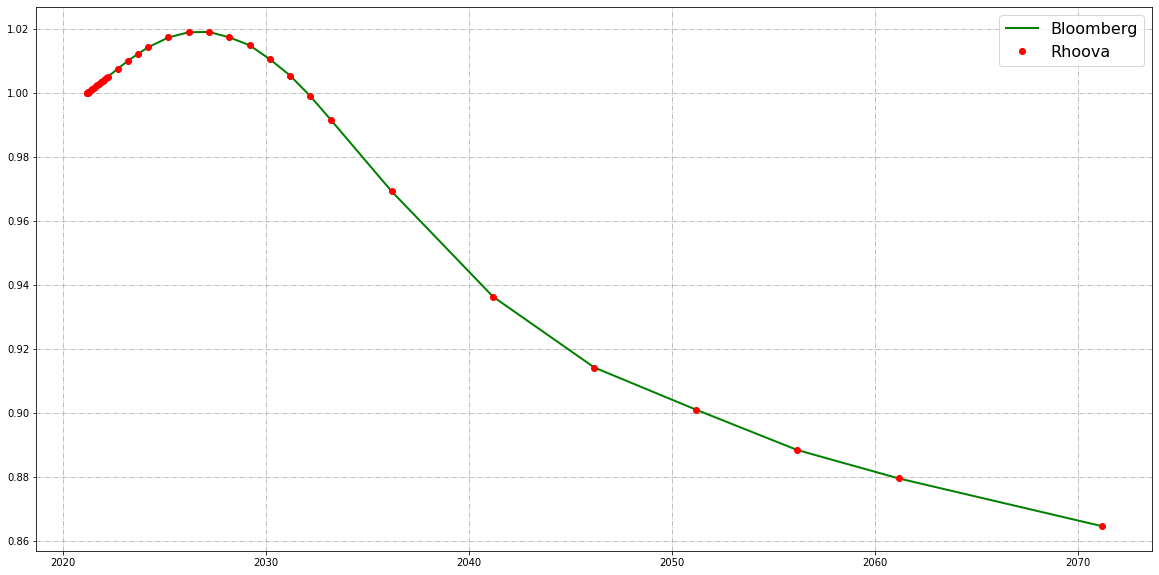

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvediscounts.keys())
y1 =bloombergdiscountrates
y2 = list(rhoovayieldcurvediscounts.values())

ax.plot(x,y1, 'g', label='Bloomberg', linewidth=2)
ax.plot(x,y2, 'ro', label='Rhoova', linewidth=12)

leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

In [13]:
pTable = pt.PrettyTable(['Maturity','Rhoova ZeroRates','Bloomberg ZR','Rhoova Discount Rate','Bloomberg DR'])
i=0
for key, val in rhoovayieldcurvedicts.items():
    pTable.add_row([key, val,bloombergzerorates[i],rhoovayieldcurvediscounts.get(key),bloombergdiscountrates[i]])
    i=i+1
pTable.align = 'c'
pTable.float_format = '.6'
print(pTable)

+------------+------------------+--------------+----------------------+--------------+
|  Maturity  | Rhoova ZeroRates | Bloomberg ZR | Rhoova Discount Rate | Bloomberg DR |
+------------+------------------+--------------+----------------------+--------------+
| 2021-03-12 |    -0.483635     |  -0.477000   |          1           |   1.000000   |
| 2021-03-15 |    -0.483635     |  -0.483630   |       1.000040       |   1.000040   |
| 2021-03-19 |    -0.486689     |  -0.486690   |       1.000093       |   1.000093   |
| 2021-03-26 |    -0.489247     |  -0.489250   |       1.000188       |   1.000188   |
| 2021-04-12 |    -0.489303     |  -0.489300   |       1.000416       |   1.000416   |
| 2021-05-12 |    -0.490924     |  -0.490920   |       1.000821       |   1.000821   |
| 2021-06-14 |    -0.491033     |  -0.491030   |       1.001265       |   1.001265   |
| 2021-07-12 |    -0.492648     |  -0.492650   |       1.001648       |   1.001648   |
| 2021-08-12 |    -0.493768     |  -0.49377

In [14]:
# Fix parameters for building yield curve

yieldcurveconfig['applyShock']={
  "method": "parallel",
  "shockValues" : [
    {
      "tenor" : "all",
      "shockValue" : 50.0
    }
  ]
}

In [15]:
result =  {
    "valuationDate": "2021-03-10",
    "endOfMonth": True,
    "yieldCurve":yieldcurveconfig ,
    "yieldData": yielddata.to_dict('r')
}
try:
    result = api.createTask(CalculationType.YIELD_CURVE, result,True)
    result=json.loads(result["result"])
except RhoovaError as e:
    e.printPretty()

In [16]:
zerorates=result.get("zeroRates"),
discountrates=result.get("discountRates")
dates=[]
forwarddates= {}
rhoovapyieldcurvedicts = {}
rhoovapyieldcurvediscounts = {}
for rhvzr in zerorates[0]:
    rhoovapyieldcurvedicts[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100
    dates.append(rhvzr.get('date'))

for rhv in discountrates:
    rhoovapyieldcurvediscounts[datetime.strptime(rhv.get('date'), '%Y-%m-%d').date()] = rhv.get('rate')
    

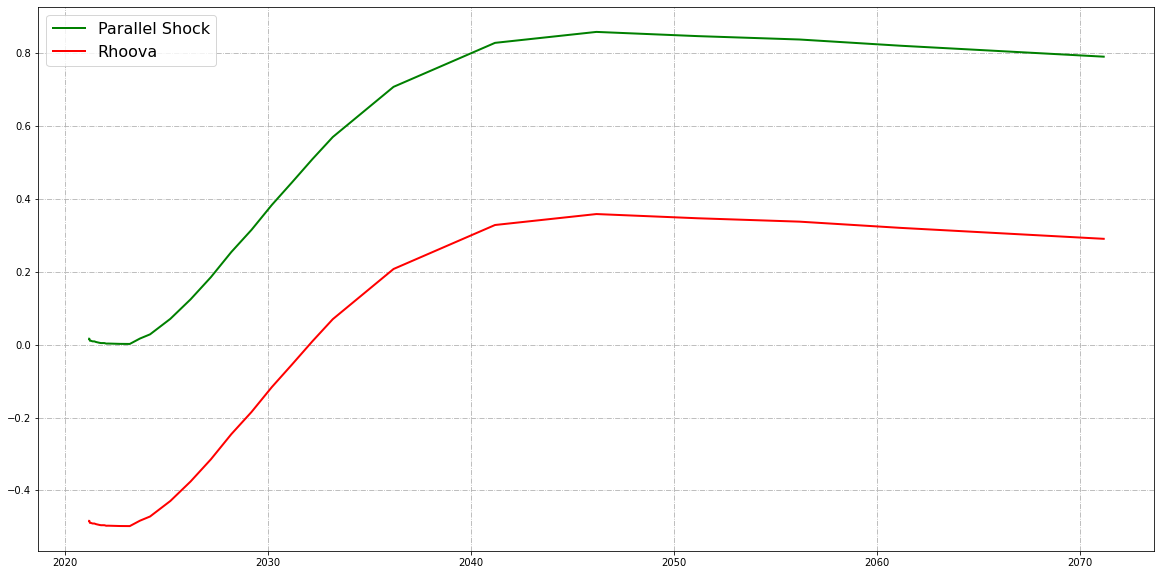

In [17]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvedicts.keys())
y1 =list(rhoovapyieldcurvedicts.values())
y2 = list(rhoovayieldcurvedicts.values())


ax.plot(x,y1, 'g', label='Parallel Shock', linewidth=2)
ax.plot(x,y2, 'r', label='Rhoova', linewidth=2)

leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

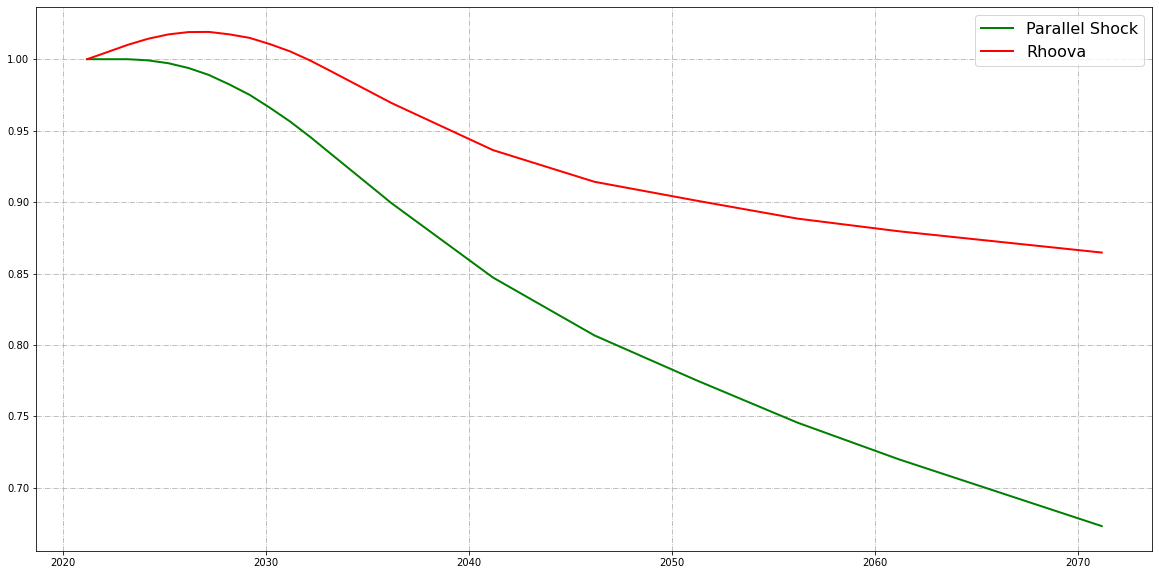

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvediscounts.keys())
y2 = list(rhoovapyieldcurvediscounts.values())
y3 = list(rhoovayieldcurvediscounts.values())


ax.plot(x,y2, 'g', label='Parallel Shock', linewidth=2)
ax.plot(x,y3, 'r', label='Rhoova', linewidth=2)


leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

In [19]:
pTable = pt.PrettyTable(['Maturity','Rhoova ZeroRates','ZeroRates with Shock','Rhoova Discount Rate','Discount Rate with Shock'])
i=0
for key, val in rhoovayieldcurvedicts.items():
    pTable.add_row([key, val,rhoovapyieldcurvedicts.get(key),rhoovayieldcurvediscounts.get(key),rhoovapyieldcurvediscounts.get(key)])
    i=i+1
pTable.align = 'c'
pTable.float_format = '.6'
print(pTable)

+------------+------------------+----------------------+----------------------+--------------------------+
|  Maturity  | Rhoova ZeroRates | ZeroRates with Shock | Rhoova Discount Rate | Discount Rate with Shock |
+------------+------------------+----------------------+----------------------+--------------------------+
| 2021-03-12 |    -0.483635     |       0.016365       |          1           |            1             |
| 2021-03-15 |    -0.483635     |       0.016365       |       1.000040       |         0.999999         |
| 2021-03-19 |    -0.486689     |       0.013311       |       1.000093       |         0.999997         |
| 2021-03-26 |    -0.489247     |       0.010753       |       1.000188       |         0.999996         |
| 2021-04-12 |    -0.489303     |       0.010697       |       1.000416       |         0.999991         |
| 2021-05-12 |    -0.490924     |       0.009076       |       1.000821       |         0.999985         |
| 2021-06-14 |    -0.491033     |    

In [20]:
yieldcurveconfig['applyShock']={
  "method": "nonparallel",
  "shockValues" : [
    {
      "tenor" : "2Y",
      "shockValue" : 20
    },
    {
      "tenor" : "5Y",
      "shockValue" : 50
    },
    {
      "tenor" : "12Y",
      "shockValue" : 25
    }
      ,
    {
      "tenor" : "50Y",
      "shockValue" : 0
    }
  ]
}


In [21]:
yieldcurve =  {
    "valuationDate": "2021-03-10",
    "endOfMonth": True,
    "yieldCurve":yieldcurveconfig ,
    "yieldData": yielddata.to_dict('r')
}
try:
    result = api.createTask(CalculationType.YIELD_CURVE, yieldcurve,True)
    result=json.loads(result["result"])
except RhoovaError as e:
    e.printPretty()

In [22]:
zerorates=result.get("zeroRates"),
discountrates=result.get("discountRates")
dates=[]
forwarddates= {}
rhoovanpyieldcurvedicts = {}
rhoovanpyieldcurvediscounts = {}
for rhvzr in zerorates[0]:
    rhoovanpyieldcurvedicts[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100
    dates.append(rhvzr.get('date'))

for rhv in discountrates:
    rhoovanpyieldcurvediscounts[datetime.strptime(rhv.get('date'), '%Y-%m-%d').date()] = rhv.get('rate')
    

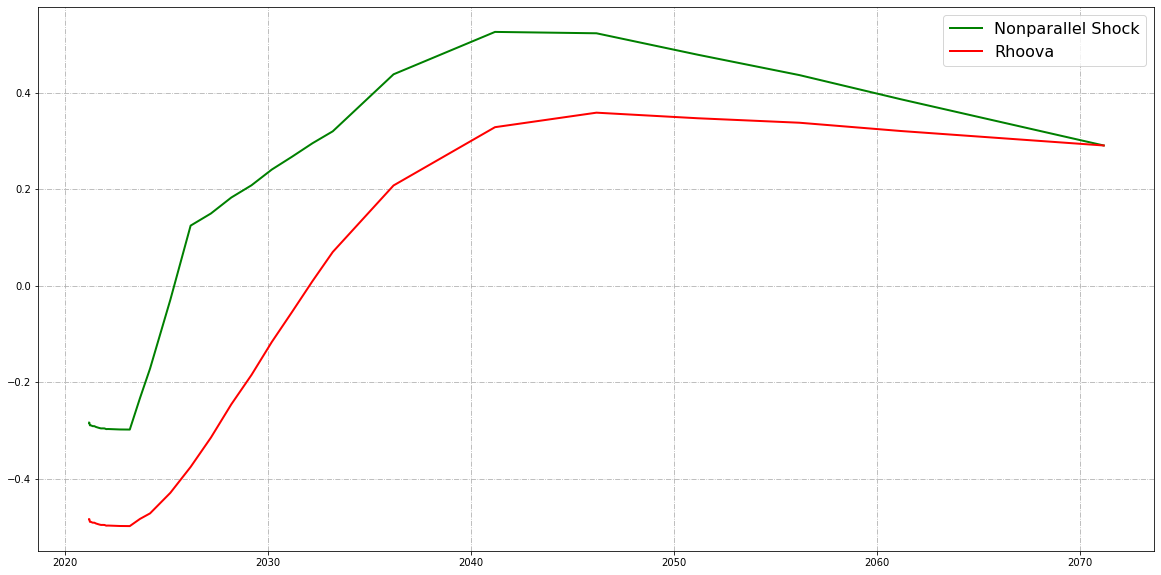

In [23]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvedicts.keys())
y1 =list(rhoovanpyieldcurvedicts.values())
y2 = list(rhoovayieldcurvedicts.values())


ax.plot(x,y1, 'g', label='Nonparallel Shock', linewidth=2)
ax.plot(x,y2, 'r', label='Rhoova', linewidth=2)

leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

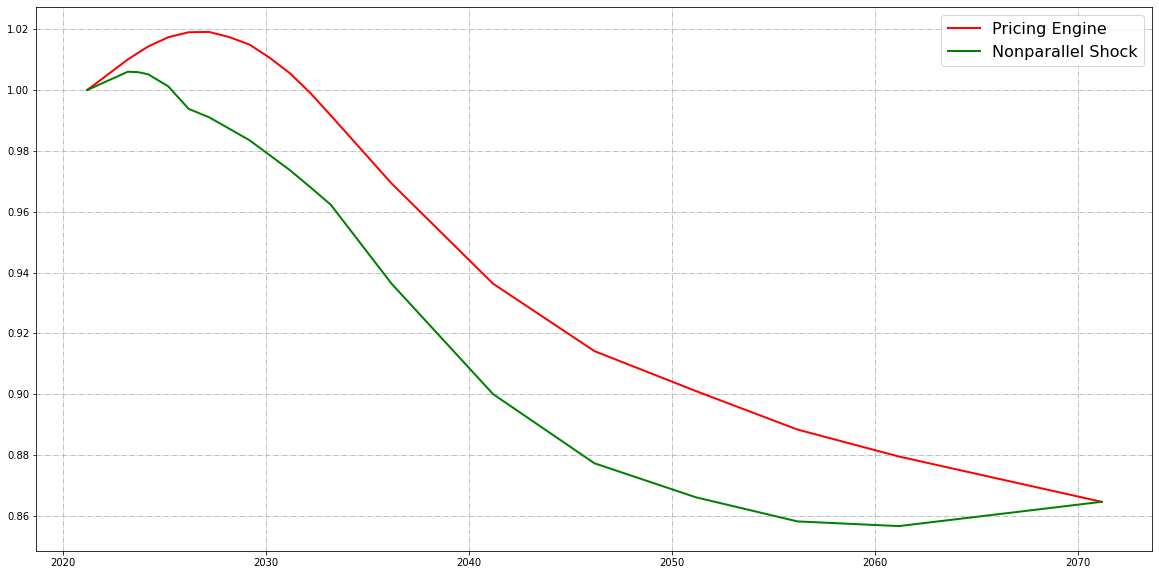

In [24]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvediscounts.keys())
y2 = list(rhoovayieldcurvediscounts.values())
y3 = list(rhoovanpyieldcurvediscounts.values())


ax.plot(x,y2, 'r', label='Pricing Engine', linewidth=2)
ax.plot(x,y3, 'g', label='Nonparallel Shock', linewidth=2)


leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

In [25]:
pTable = pt.PrettyTable(['Maturity','Rhoova ZeroRates','ZeroRates with Shock','Rhoova Discount Rate','Discount Rate with Shock'])
i=0
for key, val in rhoovayieldcurvedicts.items():
    pTable.add_row([key, val,rhoovanpyieldcurvedicts.get(key),rhoovayieldcurvediscounts.get(key),rhoovanpyieldcurvediscounts.get(key)])
    i=i+1
pTable.align = 'c'
pTable.float_format = '.6'
print(pTable)

+------------+------------------+----------------------+----------------------+--------------------------+
|  Maturity  | Rhoova ZeroRates | ZeroRates with Shock | Rhoova Discount Rate | Discount Rate with Shock |
+------------+------------------+----------------------+----------------------+--------------------------+
| 2021-03-12 |    -0.483635     |      -0.283635       |          1           |            1             |
| 2021-03-15 |    -0.483635     |      -0.283635       |       1.000040       |         1.000023         |
| 2021-03-19 |    -0.486689     |      -0.286689       |       1.000093       |         1.000055         |
| 2021-03-26 |    -0.489247     |      -0.289247       |       1.000188       |         1.000111         |
| 2021-04-12 |    -0.489303     |      -0.289303       |       1.000416       |         1.000246         |
| 2021-05-12 |    -0.490924     |      -0.290924       |       1.000821       |         1.000486         |
| 2021-06-14 |    -0.491033     |    

In [26]:
# Fix parameters for building yield curve

yieldcurveconfig['applyShock']={
  "method": "keyrate",
  "shockValues" : [
    {
      "tenor" : "259D",
      "shockValue" : 100.0
    },
    {
      "tenor" : "10Y",
      "shockValue" : 200.0
    }
  ]
}

In [27]:
result =  {
    "valuationDate": "2021-03-10",
    "endOfMonth": True,
    "yieldCurve":yieldcurveconfig ,
    "yieldData": yielddata.to_dict('r')
}
try:
    result = api.createTask(CalculationType.YIELD_CURVE, result,True)
    result=json.loads(result["result"])
except RhoovaError as e:
    e.printPretty()

In [28]:
zerorates=result.get("zeroRates"),
discountrates=result.get("discountRates")
dates=[]
forwarddates= {}
rhoovanp2yieldcurvedicts = {}
rhoovanp2yieldcurvediscounts = {}
for rhvzr in zerorates[0]:
    rhoovanp2yieldcurvedicts[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100
    dates.append(rhvzr.get('date'))

for rhv in discountrates:
    rhoovanp2yieldcurvediscounts[datetime.strptime(rhv.get('date'), '%Y-%m-%d').date()] = rhv.get('rate')
    

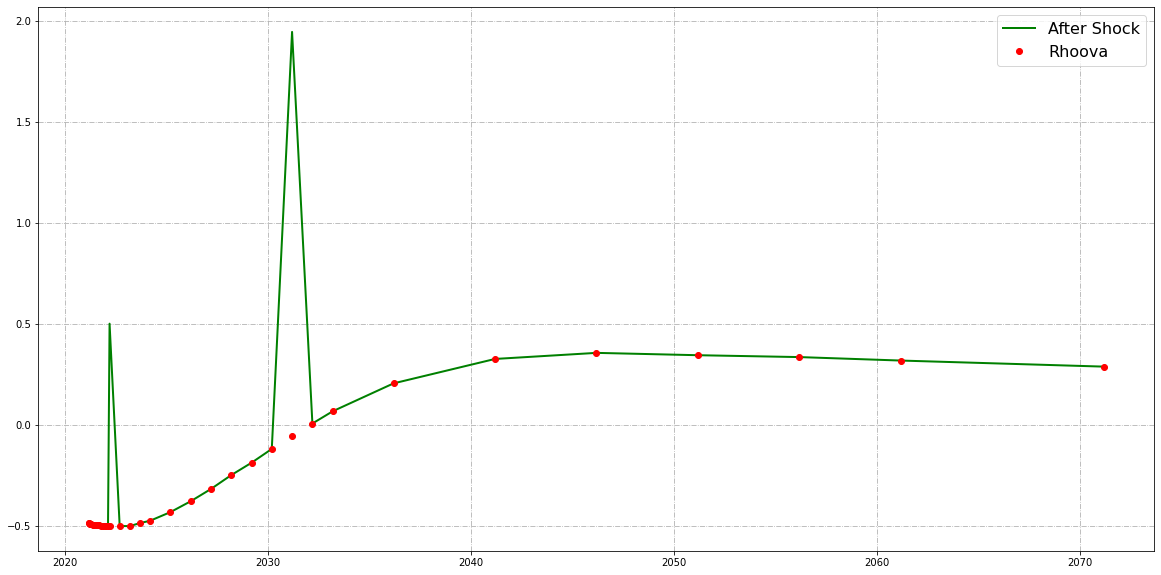

In [29]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvedicts.keys())
y1 =list(rhoovanp2yieldcurvedicts.values())
y2 = list(rhoovayieldcurvedicts.values())


ax.plot(x,y1, 'g', label='After Shock', linewidth=2)
ax.plot(x,y2, 'ro', label='Rhoova', linewidth=4)

leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

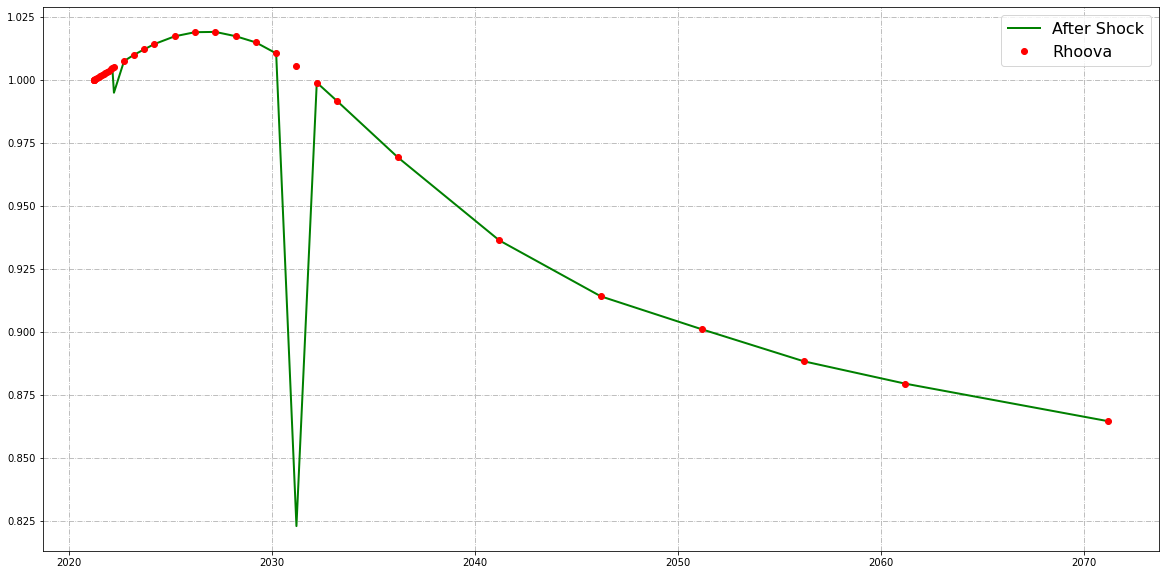

In [30]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovayieldcurvediscounts.keys())
y2 = list(rhoovanp2yieldcurvediscounts.values())
y3 = list(rhoovayieldcurvediscounts.values())


ax.plot(x,y2, 'g', label='After Shock', linewidth=2)
ax.plot(x,y3, 'ro', label='Rhoova', linewidth=2)


leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()

In [31]:
pTable = pt.PrettyTable(['Maturity','Rhoova ZeroRates','ZeroRates with Shock','Rhoova Discount Rate','Discount Rate with Shock'])
i=0
for key, val in rhoovayieldcurvedicts.items():
    pTable.add_row([key, val,rhoovanp2yieldcurvedicts.get(key),rhoovayieldcurvediscounts.get(key),rhoovanp2yieldcurvediscounts.get(key)])
    i=i+1
pTable.align = 'c'
pTable.float_format = '.6'
print(pTable)

+------------+------------------+----------------------+----------------------+--------------------------+
|  Maturity  | Rhoova ZeroRates | ZeroRates with Shock | Rhoova Discount Rate | Discount Rate with Shock |
+------------+------------------+----------------------+----------------------+--------------------------+
| 2021-03-12 |    -0.483635     |      -0.483635       |          1           |            1             |
| 2021-03-15 |    -0.483635     |      -0.483635       |       1.000040       |         1.000040         |
| 2021-03-19 |    -0.486689     |      -0.486689       |       1.000093       |         1.000093         |
| 2021-03-26 |    -0.489247     |      -0.489247       |       1.000188       |         1.000188         |
| 2021-04-12 |    -0.489303     |      -0.489303       |       1.000416       |         1.000416         |
| 2021-05-12 |    -0.490924     |      -0.490924       |       1.000821       |         1.000821         |
| 2021-06-14 |    -0.491033     |    

In [32]:
# Fix parameters for building yield curve
yieldcurveconfig['applyShock']={
  "method": "keyrate",
  "shockValues" : [
    {
      "tenor" : "2Y",
      "shockValue" : 100.0
    }
  ]
}

In [33]:
from datetime import datetime

zerodates=list(pd.date_range(start="2021-06-04",end="2071-06-04 "))
zeros=[]
for i in zerodates:
    zeros.append(i.strftime("%Y-%m-%d"))

In [34]:
result =  {
    "valuationDate": "2021-03-10",
    "zeroRates": {
        "analysisDates": zeros,
        "compounding": "Continuous",
        "frequency": "Annual",
        "dayCounter":"Actual360"
    },
    "endOfMonth": True,
    "yieldCurve":yieldcurveconfig ,
    "yieldData": yielddata.to_dict('r')
}
try:
    result = api.createTask(CalculationType.YIELD_CURVE, result,True)
    result=json.loads(result["result"])
except RhoovaError as e:
    e.printPretty()

In [35]:
zerorates=result.get("zeroRates"),
discountrates=result.get("discountRates")
dates=[]
forwarddates= {}
rhoovanp2yieldcurvedicts = {}
rhoovanp2yieldcurvediscounts = {}
for rhvzr in zerorates[0]:
    rhoovanp2yieldcurvedicts[datetime.strptime(rhvzr.get('date'),'%Y-%m-%d').date()] = rhvzr.get('rate')*100
    dates.append(rhvzr.get('date'))

for rhv in discountrates:
    rhoovanp2yieldcurvediscounts[datetime.strptime(rhv.get('date'), '%Y-%m-%d').date()] = rhv.get('rate')
    

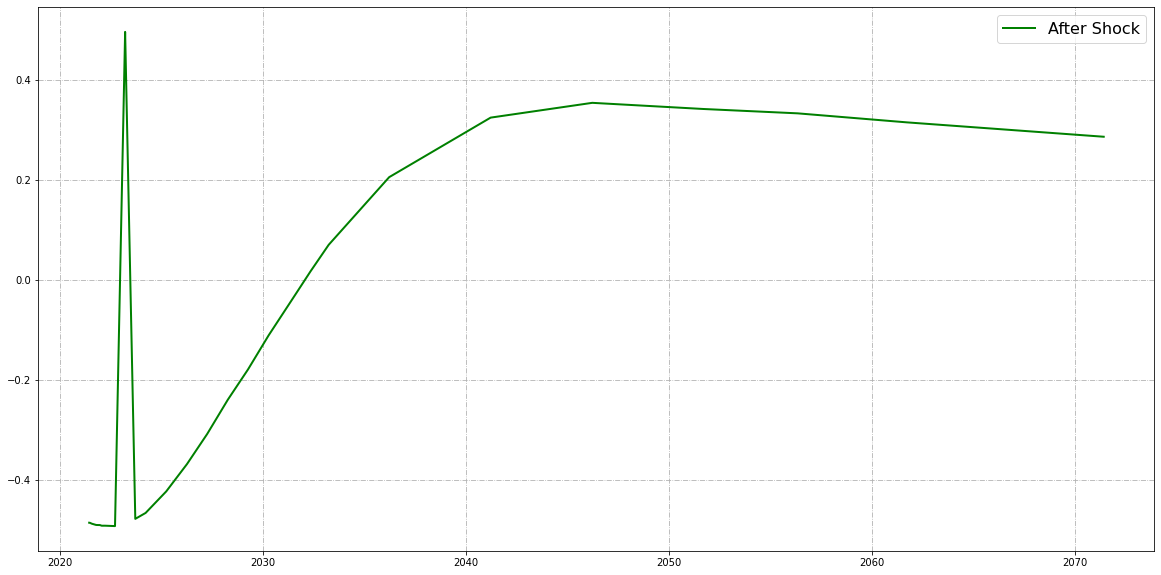

In [36]:
fig, ax = plt.subplots(figsize=(20, 10))

x=list(rhoovanp2yieldcurvedicts.keys())
y1 =list(rhoovanp2yieldcurvedicts.values())


ax.plot(x,y1, 'g', label='After Shock', linewidth=2)

leg = ax.legend(prop={'size': 16});
plt.grid(linestyle='dashdot')
plt.show()